1. 기획
크롤링 목적

인터넷에서 의류를 구매 시 사이즈를 한 눈에 알아보기 힘들다는 점이 있음
무신사에서는 사이즈의 크다 보통 작다를 그래프로 보여주지만 
신체 사이즈별 그래프가 아닌 단순 고객들의 사이즈 구매를 그래프로 한것으로 보여
자신의 신체사이즈에 맞는 데이터를 한눈에 시각화를 해보고 싶었다.

각 구매자들의 키와 몸무게와 구매사이즈, 만족도를 크롤링하여
크롤링한 데이터를 전처리 과정을 거쳐 시각화를 해보려고 했다. 

그와 같이 텍스트 시각화를 하기위해 konlpy를 이용
워드클라우드를 이용하여 텍스트 시각화까지 해보았다.

In [1]:
# 실기 제출할때 플라타함수, 라인차트 사용

# 평가기준
# 1. 기획
# 2. 크롤링 코드(셀레늄, request, bs4, 공공데이터 포탈 ) + 시각화
# 3. 데이터 전처리
# 4. 데이터 시각화 (pie, line, geo, bubble, keyword 등 차트 활용)
# 5. 데이터 저장

In [71]:
import pandas as pd  # 판다스 : 데이터분석 라이브러리
import numpy as np   # 넘파이 : 숫자, 행렬 데이터 라이브러리
import requests 
import re  # 정규표현식

from bs4 import BeautifulSoup    # html 데이터를 전처리
from selenium import webdriver   # 웹 브라우저 자동화
from selenium.webdriver.common.keys import Keys
import chromedriver_autoinstaller

import time    # 서버와 통신할 때 중간중간 시간 지연. 보통은 1초
from tqdm import tqdm_notebook   # for문 돌릴 때 진행상황을 %게이지로 알려준다.

# 워닝 무시
import warnings
warnings.filterwarnings('ignore')

In [72]:
# Step 1. 크롬 웹브라우저 실행
# pip install chromedriver_autoinstaller
chrome_path = chromedriver_autoinstaller.install()
driver = webdriver.Chrome(chrome_path)

# 사이트 주소는 네이버
driver.get('https:/www.musinsa.com')
time.sleep(2)  # 2초간 정지


In [5]:
# 검색어, 검색 기간 정의
query_txt = input('1.크롤링할 키워드는 무엇입니까?: ')

#검색창  텍스트 제거
element = driver.find_element_by_id("search_query")
element.clear()

# Step 2. 네이버 검색창에 "검색어" 검색
element.send_keys(query_txt)  # query_txt는 위에서 입력한 키워드
element.submit()
time.sleep(2)

# 첫번째 옷 클릭
CSS_tran=".img-block"                         
driver.find_element_by_css_selector(CSS_tran).click()   # 사진 클릭
time.sleep(2)

1.크롤링할 키워드는 무엇입니까?: 마크곤잘레스 맨투맨


In [8]:
#팝업창 닫기 1
close1 = '.btn.btn-close'
driver.find_element_by_css_selector(close1).click()
time.sleep(2)
driver.execute_script("window.scrollTo(0, 8800)")
time.sleep(1)

ElementNotInteractableException: Message: element not interactable
  (Session info: chrome=97.0.4692.71)
Stacktrace:
Backtrace:
	Ordinal0 [0x00A60613+2557459]
	Ordinal0 [0x009F79D1+2128337]
	Ordinal0 [0x008F2CC0+1060032]
	Ordinal0 [0x0091F30E+1241870]
	Ordinal0 [0x00914F83+1200003]
	Ordinal0 [0x00937A5C+1342044]
	Ordinal0 [0x00914954+1198420]
	Ordinal0 [0x00937B64+1342308]
	Ordinal0 [0x0094753A+1406266]
	Ordinal0 [0x009378C6+1341638]
	Ordinal0 [0x00913686+1193606]
	Ordinal0 [0x00914516+1197334]
	GetHandleVerifier [0x00BFA922+1624850]
	GetHandleVerifier [0x00CA85FC+2336748]
	GetHandleVerifier [0x00AF4041+549425]
	GetHandleVerifier [0x00AF3143+545587]
	Ordinal0 [0x009FD34E+2151246]
	Ordinal0 [0x00A01918+2169112]
	Ordinal0 [0x00A01A60+2169440]
	Ordinal0 [0x00A0B650+2209360]
	BaseThreadInitThunk [0x7701FA29+25]
	RtlGetAppContainerNamedObjectPath [0x77B57A9E+286]
	RtlGetAppContainerNamedObjectPath [0x77B57A6E+238]


In [6]:
#팝업창 닫기 2
close2 = '.Commonstyled__PreviewCloseButton-sc-1uivlpa-3.jOVdaf'
driver.find_element_by_css_selector(close2).click()

In [16]:
# 총 페이지 수 
page = driver.find_element_by_xpath('//*[@id="reviewListFragment"]/div[11]/div[1]')
page.text.split(' ')[0]
total = int(page.text.split(' ')[0])

In [10]:
user_info = [] # 유저 정보 리스트
size_info = [] # 유저 구매 사이즈 리스트
review_info = []  # 사이즈 평 리스트
text_info = [] # 리뷰 글리스트
star_info = [] # 별점 리스트 
size_list = [] # 사이즈 크다 작다 딱 맞다 정보만 추출 

m = list(range(1,10))
for k in tqdm_notebook(list(map(str, m))):
    try :
    # 옷 사이즈 정보 
        size_in = driver.find_elements_by_css_selector(".review-goods-information__option-wrap")
    # 유저 정보 
        reviews = driver.find_elements_by_css_selector(".review-profile__body_information")
    # 사이즈 리뷰  
        size_re = driver.find_elements_by_css_selector('.review-evaluation__item')
    #텍스트 리스트
        text_li = driver.find_elements_by_css_selector('.review-contents__text')
    # 리뷰 별점(별 width %로 표시) 수집
        element = driver.find_elements_by_css_selector('.review-list__rating__active')
        
        # 유저 정보 
        for user in reviews:
            u_info = user.text
            user_info.append(u_info)
        # 옷 사이즈 정보 
        for size in size_in:
            cl_size = size.text
            size_info.append(cl_size[:1])
        # 사이즈 리뷰  
        for s_review in size_re:
            s_r = s_review.text
            review_info.append(s_r)
            
# 리뷰 별점 width로 수집 후, 5점 만점 숫자로 변환하기
        for i in range(len(element)):
            width = element[i].get_attribute('style')
        #print(width)
        # 숫자에 따라 별점으로 변환하기
            percent_star = int(re.findall('\d+', width)[0])
            percent_star = percent_star*0.05
            star_info.append(percent_star)
# 리뷰 글 
        for text in text_li:
            t_li = text.text
            text_info.append(t_li)
            
        if int(k) % 5 == 0: 
            driver.find_element_by_xpath('//*[@id="reviewListFragment"]/div[11]/div[2]/div/a[8]').click()
            
        driver.find_element_by_link_text(k).click()
        time.sleep(7)
        
    except:
        driver.find_element_by_link_text(k).click()
        time.sleep(7)

        
for i in review_info[::4]:
    size_list.append(i)

  0%|          | 0/9 [00:00<?, ?it/s]

ElementClickInterceptedException: Message: element click intercepted: Element <a href="javascript:void(0);" class="paging-btn btn active" onclick="ReviewPage.goPage(...); return false;">1</a> is not clickable at point (848, 890). Other element would receive the click: <div class="code box-btn-leftbottom" fragment="104bc01b1b3">...</div>
  (Session info: chrome=97.0.4692.71)
Stacktrace:
Backtrace:
	Ordinal0 [0x00A60613+2557459]
	Ordinal0 [0x009F79D1+2128337]
	Ordinal0 [0x008F2DF8+1060344]
	Ordinal0 [0x0092482F+1263663]
	Ordinal0 [0x00922A70+1256048]
	Ordinal0 [0x009206CB+1246923]
	Ordinal0 [0x0091F4B9+1242297]
	Ordinal0 [0x00914F83+1200003]
	Ordinal0 [0x00937A5C+1342044]
	Ordinal0 [0x00914954+1198420]
	Ordinal0 [0x00937B64+1342308]
	Ordinal0 [0x0094753A+1406266]
	Ordinal0 [0x009378C6+1341638]
	Ordinal0 [0x00913686+1193606]
	Ordinal0 [0x00914516+1197334]
	GetHandleVerifier [0x00BFA922+1624850]
	GetHandleVerifier [0x00CA85FC+2336748]
	GetHandleVerifier [0x00AF4041+549425]
	GetHandleVerifier [0x00AF3143+545587]
	Ordinal0 [0x009FD34E+2151246]
	Ordinal0 [0x00A01918+2169112]
	Ordinal0 [0x00A01A60+2169440]
	Ordinal0 [0x00A0B650+2209360]
	BaseThreadInitThunk [0x7701FA29+25]
	RtlGetAppContainerNamedObjectPath [0x77B57A9E+286]
	RtlGetAppContainerNamedObjectPath [0x77B57A6E+238]


In [28]:
#사이즈 작다 크다 보통이다 리스트 
fit_list = []
for word in size_list:
    a = word.split('\n')
    fit_list.append(a[1])

In [42]:
df = pd.DataFrame({'user':user_info, 'size':size_info,'fit':fit_list,'star':star_info,'text':text_info})
df

ValueError: All arrays must be of the same length

In [43]:
df

,user,size,fit,star,text
0,"남성, 178cm, 62kg",L,커요,4.0,역시 마크 곤잘레스여서 그런지 확실히 예쁘긴 하네요...가격도 블랙 프라이데이때 사...
1,"여성, 165cm, 50kg",S,보통이에요,5.0,커플티 맞췃는데 가격도 나쁘지않고 이쁘고 잘 맞고 좋네용
2,"남성, 178cm, 60kg",M,보통이에요,5.0,무난무난한 맨투맨입니다. 정사이즈로 샀는데 기장감이 딱 좋았어요. 편하게 입을 수 ...
3,"남성, 182cm, 72kg",L,보통이에요,5.0,가성비갑~ 적당한 오버핏에 얇지도 두껍지도 않아서 너무좋아요
4,"남성, 165cm, 80kg",X,보통이에요,5.0,엄청 편하고 데일리로 입기 좋아요! 거의 교복입니다
...,...,...,...,...,...
85,"남성, 170cm, 65kg",M,보통이에요,5.0,너무 오버핏도 아니고 사이즈가 적당해서 너무 부해보이지도 않고 딱 좋아요
86,"남성, 178cm, 67kg",L,보통이에요,5.0,스몰로고가 포인트인 이 옷! 사이즈도 넉넉하고 딱 떨어지는 핏이라 이쁩니다~
87,"남성, 174cm, 78kg",X,보통이에요,5.0,잘 받았습니다 감사합니다\n딱 맞은 사이즈 세일해서 잘 샀습니다
88,"남성, 180cm, 73kg",L,커요,5.0,오버사이즈로 잘 나왓구요~ 편하게 입고 다니기에 좋습니다


In [ ]:
# 5페이지 이후 페이지 넘겨보기 
m = list(range(2,total))
for k in list(map(str, m)):
    try :
        if int(k) % 5 == 0: 
            driver.find_element_by_xpath('//*[@id="reviewListFragment"]/div[11]/div[2]/div/a[8]').click()
            
        driver.find_element_by_link_text(k).click()
        time.sleep(2)
    except:
        driver.find_element_by_link_text(k).click()

In [51]:
df['gender'] = df['user'].str[:2] 
df['height'] = df['user'].str[4:9]
df['weight'] = df['user'].str[11:15]

In [52]:
df

,user,size,fit,star,text,gender,height,weight
0,"남성, 178cm, 62kg",L,커요,4.0,역시 마크 곤잘레스여서 그런지 확실히 예쁘긴 하네요...가격도 블랙 프라이데이때 사...,남성,178cm,62kg
1,"여성, 165cm, 50kg",S,보통이에요,5.0,커플티 맞췃는데 가격도 나쁘지않고 이쁘고 잘 맞고 좋네용,여성,165cm,50kg
2,"남성, 178cm, 60kg",M,보통이에요,5.0,무난무난한 맨투맨입니다. 정사이즈로 샀는데 기장감이 딱 좋았어요. 편하게 입을 수 ...,남성,178cm,60kg
3,"남성, 182cm, 72kg",L,보통이에요,5.0,가성비갑~ 적당한 오버핏에 얇지도 두껍지도 않아서 너무좋아요,남성,182cm,72kg
4,"남성, 165cm, 80kg",X,보통이에요,5.0,엄청 편하고 데일리로 입기 좋아요! 거의 교복입니다,남성,165cm,80kg
...,...,...,...,...,...,...,...,...
85,"남성, 170cm, 65kg",M,보통이에요,5.0,너무 오버핏도 아니고 사이즈가 적당해서 너무 부해보이지도 않고 딱 좋아요,남성,170cm,65kg
86,"남성, 178cm, 67kg",L,보통이에요,5.0,스몰로고가 포인트인 이 옷! 사이즈도 넉넉하고 딱 떨어지는 핏이라 이쁩니다~,남성,178cm,67kg
87,"남성, 174cm, 78kg",X,보통이에요,5.0,잘 받았습니다 감사합니다\n딱 맞은 사이즈 세일해서 잘 샀습니다,남성,174cm,78kg
88,"남성, 180cm, 73kg",L,커요,5.0,오버사이즈로 잘 나왓구요~ 편하게 입고 다니기에 좋습니다,남성,180cm,73kg


In [70]:
# 저장하기
df.to_csv("musinsa.csv",encoding = 'utf-8-sig')
# df.to_csv("blog_url.csv")

NameError: name 'df' is not defined

In [11]:
import matplotlib.pyplot as plt  # 시각화 라이브러리
import seaborn as sns            # 시각화 라이브러리
# import plotly      # interactive visualization library

In [12]:
musinsa= pd.read_csv('./musinsa.csv')
musinsa

,Unnamed: 0,user,size,fit,star,text,gender,height,weight
0,0,"남성, 178cm, 62kg",L,커요,4.0,역시 마크 곤잘레스여서 그런지 확실히 예쁘긴 하네요...가격도 블랙 프라이데이때 사...,남성,178cm,62kg
1,1,"여성, 165cm, 50kg",S,보통이에요,5.0,커플티 맞췃는데 가격도 나쁘지않고 이쁘고 잘 맞고 좋네용,여성,165cm,50kg
2,2,"남성, 178cm, 60kg",M,보통이에요,5.0,무난무난한 맨투맨입니다. 정사이즈로 샀는데 기장감이 딱 좋았어요. 편하게 입을 수 ...,남성,178cm,60kg
3,3,"남성, 182cm, 72kg",L,보통이에요,5.0,가성비갑~ 적당한 오버핏에 얇지도 두껍지도 않아서 너무좋아요,남성,182cm,72kg
4,4,"남성, 165cm, 80kg",X,보통이에요,5.0,엄청 편하고 데일리로 입기 좋아요! 거의 교복입니다,남성,165cm,80kg
...,...,...,...,...,...,...,...,...,...
85,85,"남성, 170cm, 65kg",M,보통이에요,5.0,너무 오버핏도 아니고 사이즈가 적당해서 너무 부해보이지도 않고 딱 좋아요,남성,170cm,65kg
86,86,"남성, 178cm, 67kg",L,보통이에요,5.0,스몰로고가 포인트인 이 옷! 사이즈도 넉넉하고 딱 떨어지는 핏이라 이쁩니다~,남성,178cm,67kg
87,87,"남성, 174cm, 78kg",X,보통이에요,5.0,잘 받았습니다 감사합니다\n딱 맞은 사이즈 세일해서 잘 샀습니다,남성,174cm,78kg
88,88,"남성, 180cm, 73kg",L,커요,5.0,오버사이즈로 잘 나왓구요~ 편하게 입고 다니기에 좋습니다,남성,180cm,73kg


In [13]:
musinsa.loc[(musinsa['size'] == 'X'),'size'] = 'XL' 
musinsa

,Unnamed: 0,user,size,fit,star,text,gender,height,weight
0,0,"남성, 178cm, 62kg",L,커요,4.0,역시 마크 곤잘레스여서 그런지 확실히 예쁘긴 하네요...가격도 블랙 프라이데이때 사...,남성,178cm,62kg
1,1,"여성, 165cm, 50kg",S,보통이에요,5.0,커플티 맞췃는데 가격도 나쁘지않고 이쁘고 잘 맞고 좋네용,여성,165cm,50kg
2,2,"남성, 178cm, 60kg",M,보통이에요,5.0,무난무난한 맨투맨입니다. 정사이즈로 샀는데 기장감이 딱 좋았어요. 편하게 입을 수 ...,남성,178cm,60kg
3,3,"남성, 182cm, 72kg",L,보통이에요,5.0,가성비갑~ 적당한 오버핏에 얇지도 두껍지도 않아서 너무좋아요,남성,182cm,72kg
4,4,"남성, 165cm, 80kg",XL,보통이에요,5.0,엄청 편하고 데일리로 입기 좋아요! 거의 교복입니다,남성,165cm,80kg
...,...,...,...,...,...,...,...,...,...
85,85,"남성, 170cm, 65kg",M,보통이에요,5.0,너무 오버핏도 아니고 사이즈가 적당해서 너무 부해보이지도 않고 딱 좋아요,남성,170cm,65kg
86,86,"남성, 178cm, 67kg",L,보통이에요,5.0,스몰로고가 포인트인 이 옷! 사이즈도 넉넉하고 딱 떨어지는 핏이라 이쁩니다~,남성,178cm,67kg
87,87,"남성, 174cm, 78kg",XL,보통이에요,5.0,잘 받았습니다 감사합니다\n딱 맞은 사이즈 세일해서 잘 샀습니다,남성,174cm,78kg
88,88,"남성, 180cm, 73kg",L,커요,5.0,오버사이즈로 잘 나왓구요~ 편하게 입고 다니기에 좋습니다,남성,180cm,73kg


In [14]:
Mans = musinsa[musinsa.gender=='남성']
Mans = Mans[['gender','height','weight','fit','size']]

#여성
Girls = musinsa[musinsa.gender=='여성']
Girls = Girls[['gender','height','weight','fit','size']]

In [15]:
Mans

,gender,height,weight,fit,size
0,남성,178cm,62kg,커요,L
2,남성,178cm,60kg,보통이에요,M
3,남성,182cm,72kg,보통이에요,L
4,남성,165cm,80kg,보통이에요,XL
5,남성,170cm,65kg,커요,M
...,...,...,...,...,...
85,남성,170cm,65kg,보통이에요,M
86,남성,178cm,67kg,보통이에요,L
87,남성,174cm,78kg,보통이에요,XL
88,남성,180cm,73kg,커요,L


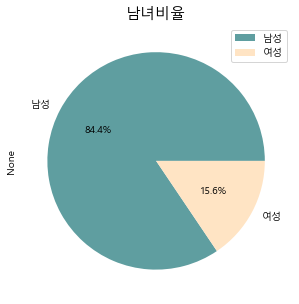

In [16]:
# 남녀 비율 
g_grup = musinsa.groupby('gender')
g_grup_sr = g_grup.size()

#한글 꺠짐 방지
plt.rcParams['font.family'] ='Malgun Gothic'
plt.rcParams['axes.unicode_minus'] =False

# 남녀 비율 표시 파이 차트 
g_grup_sr.plot(kind='pie',figsize=(7,5),autopct='%.1f%%',colors=['cadetblue','bisque'])
plt.title('남녀비율',size = 15)
plt.legend(g_grup_sr.index,loc='best')
plt.show()

In [17]:
musinsa.text

0     역시 마크 곤잘레스여서 그런지 확실히 예쁘긴 하네요...가격도 블랙 프라이데이때 사...
1                       커플티 맞췃는데 가격도 나쁘지않고 이쁘고 잘 맞고 좋네용
2     무난무난한 맨투맨입니다. 정사이즈로 샀는데 기장감이 딱 좋았어요. 편하게 입을 수 ...
3                     가성비갑~ 적당한 오버핏에 얇지도 두껍지도 않아서 너무좋아요
4                          엄청 편하고 데일리로 입기 좋아요! 거의 교복입니다
                            ...                        
85             너무 오버핏도 아니고 사이즈가 적당해서 너무 부해보이지도 않고 딱 좋아요
86           스몰로고가 포인트인 이 옷! 사이즈도 넉넉하고 딱 떨어지는 핏이라 이쁩니다~
87                  잘 받았습니다 감사합니다\n딱 맞은 사이즈 세일해서 잘 샀습니다
88                      오버사이즈로 잘 나왓구요~ 편하게 입고 다니기에 좋습니다
89                            기본블랙 색깔이라서 심플하고 깔끔하니 좋습니다
Name: text, Length: 90, dtype: object

In [18]:
# 텍스트 값 리스트로 변환 
content_list = musinsa.text.values.tolist()

In [73]:
import scipy as sp

from konlpy.tag import Kkma       ; kkma = Kkma()
from konlpy.tag import Hannanum   ; hannanum = Hannanum()
from konlpy.tag import Okt        ; t = Okt()
from konlpy.tag import *
import pickle

# from sklearn.feature_extraction.text import CountVectorizer
# from sklearn.feature_extraction.text import TfidfVectorizer
# from sklearn.linear_model import LogisticRegression
# from sklearn.pipeline import Pipeline
# from sklearn.metrics import accuracy_score
# from sklearn.model_selection import train_test_split

# 그래프
%matplotlib inline
import os
import graphviz             
from sklearn.tree import export_graphviz

# matplotlib 그래프 한글폰트 깨질 때 대처(Mac & Window)
import matplotlib
from matplotlib import font_manager, rc
import platform

if platform.system() == 'Windows':
# 윈도우인 경우
    font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
    rc('font', family=font_name)
else:    
# Mac 인 경우
    rc('font', family='AppleGothic')
    
# 그래프에서 마이너스 기호가 표시되도록 하는 설정
matplotlib.rcParams['axes.unicode_minus'] = False

import warnings  
warnings.filterwarnings('ignore')

In [74]:
import nltk
from konlpy.tag import Okt; t = Okt()

In [75]:
# 리스트 중 str 타입이 아닌 요소들(nan값)이 존재함을 확인
for i in content_list:
    if type(i) == float:
        i = str(i)
        print(i)
        
# str 타입이 아닌 요소들이 있으면 전부 str 타입으로 바꿔라!
for i in range(len(content_list)):
    if type(content_list[i]) != str:
        content_list[i] = str(content_list[i])

In [76]:
content_list

['역시 마크 곤잘레스여서 그런지 확실히 예쁘긴 하네요...가격도 블랙 프라이데이때 사서 싸게 잘 샀구요\n마크 곤잘레스여서 맨투맨 가격이 이해가 되긴하지만 살짝 비싼감이 없지 않나해요.\n특히 흰티랑 궁합이 좋은 듯해요. 요즘 날씨에 안에 흰티 입고 이거 입고 밖에 나갈 수 있어요.\n어느정도 돈이 넉넉하신 분은 이걸 구매하는 것도 나쁘지 않을 선택이에요',
 '커플티 맞췃는데 가격도 나쁘지않고 이쁘고 잘 맞고 좋네용',
 '무난무난한 맨투맨입니다. 정사이즈로 샀는데 기장감이 딱 좋았어요. 편하게 입을 수 있어서 손이 자주 갑니다!',
 '가성비갑~ 적당한 오버핏에 얇지도 두껍지도 않아서 너무좋아요',
 '엄청 편하고 데일리로 입기 좋아요! 거의 교복입니다',
 '오버핏으로 입기 좋습니다.\n너무 두껍거나 얇지도 않은 적당한 두께감도 마음에 듭니다.\n로고도 깔끔하고 이쁩니다.',
 '얇아서 가을에 입기 좋고 무난무낭하게 입기 좋아요',
 '마크곤잘레스 검정 맨투맨사고 레이어드 하기 좋아서 회색도 샀어요',
 '똑같은 디자인 다른 색상으로 또 다시 마크곤잘레스 맨투맨을 재구매 했습니다.. 디자인이 너무 예뻐서 계속 사게 되네요!!',
 '저희 동생인데 애가 조금 근육이 있다보니깐 옷핏이 잘서네요. 3대 600정도 침. 특히 어깨가 좁아서 딱 맞아요.',
 '역시 마크 곤잘레스여서 그런지 확실히 예쁘긴 하네요...가격도 블랙 프라이데이때 사서 싸게 잘 샀구요\n마크 곤잘레스여서 맨투맨 가격이 이해가 되긴하지만 살짝 비싼감이 없지 않나해요.\n특히 흰티랑 궁합이 좋은 듯해요. 요즘 날씨에 안에 흰티 입고 이거 입고 밖에 나갈 수 있어요.\n어느정도 돈이 넉넉하신 분은 이걸 구매하는 것도 나쁘지 않을 선택이에요',
 '커플티 맞췃는데 가격도 나쁘지않고 이쁘고 잘 맞고 좋네용',
 '무난무난한 맨투맨입니다. 정사이즈로 샀는데 기장감이 딱 좋았어요. 편하게 입을 수 있어서 손이 자주 갑니다!',
 '가성비갑~ 적당한 오버핏에 얇지도 두껍지도 않아서 너무좋아요',
 '

In [77]:
# 수집한 글들을 한 문장으로 합치기
content_text = ''

for each_line in content_list[:2000]:
    content_text = content_text + each_line + '\n'

content_text

'역시 마크 곤잘레스여서 그런지 확실히 예쁘긴 하네요...가격도 블랙 프라이데이때 사서 싸게 잘 샀구요\n마크 곤잘레스여서 맨투맨 가격이 이해가 되긴하지만 살짝 비싼감이 없지 않나해요.\n특히 흰티랑 궁합이 좋은 듯해요. 요즘 날씨에 안에 흰티 입고 이거 입고 밖에 나갈 수 있어요.\n어느정도 돈이 넉넉하신 분은 이걸 구매하는 것도 나쁘지 않을 선택이에요\n커플티 맞췃는데 가격도 나쁘지않고 이쁘고 잘 맞고 좋네용\n무난무난한 맨투맨입니다. 정사이즈로 샀는데 기장감이 딱 좋았어요. 편하게 입을 수 있어서 손이 자주 갑니다!\n가성비갑~ 적당한 오버핏에 얇지도 두껍지도 않아서 너무좋아요\n엄청 편하고 데일리로 입기 좋아요! 거의 교복입니다\n오버핏으로 입기 좋습니다.\n너무 두껍거나 얇지도 않은 적당한 두께감도 마음에 듭니다.\n로고도 깔끔하고 이쁩니다.\n얇아서 가을에 입기 좋고 무난무낭하게 입기 좋아요\n마크곤잘레스 검정 맨투맨사고 레이어드 하기 좋아서 회색도 샀어요\n똑같은 디자인 다른 색상으로 또 다시 마크곤잘레스 맨투맨을 재구매 했습니다.. 디자인이 너무 예뻐서 계속 사게 되네요!!\n저희 동생인데 애가 조금 근육이 있다보니깐 옷핏이 잘서네요. 3대 600정도 침. 특히 어깨가 좁아서 딱 맞아요.\n역시 마크 곤잘레스여서 그런지 확실히 예쁘긴 하네요...가격도 블랙 프라이데이때 사서 싸게 잘 샀구요\n마크 곤잘레스여서 맨투맨 가격이 이해가 되긴하지만 살짝 비싼감이 없지 않나해요.\n특히 흰티랑 궁합이 좋은 듯해요. 요즘 날씨에 안에 흰티 입고 이거 입고 밖에 나갈 수 있어요.\n어느정도 돈이 넉넉하신 분은 이걸 구매하는 것도 나쁘지 않을 선택이에요\n커플티 맞췃는데 가격도 나쁘지않고 이쁘고 잘 맞고 좋네용\n무난무난한 맨투맨입니다. 정사이즈로 샀는데 기장감이 딱 좋았어요. 편하게 입을 수 있어서 손이 자주 갑니다!\n가성비갑~ 적당한 오버핏에 얇지도 두껍지도 않아서 너무좋아요\n엄청 편하고 데일리로 입기 좋아요! 거의 교복입니다\n오버핏으로 입기 좋습니다

In [78]:
tokens_ko = t.morphs(content_text)
tokens_ko

['역시',
 '마크',
 '곤잘레스',
 '여서',
 '그런지',
 '확실히',
 '예쁘긴',
 '하네요',
 '...',
 '가격',
 '도',
 '블랙',
 '프라이데이',
 '때',
 '사서',
 '싸게',
 '잘',
 '샀구요',
 '\n',
 '마크',
 '곤잘레스',
 '여서',
 '맨',
 '투맨',
 '가격',
 '이',
 '이해',
 '가',
 '되긴',
 '하지만',
 '살짝',
 '비싼',
 '감',
 '이',
 '없지',
 '않나',
 '해',
 '요',
 '.',
 '\n',
 '특히',
 '흰',
 '티',
 '랑',
 '궁합',
 '이',
 '좋은',
 '듯',
 '해요',
 '.',
 '요즘',
 '날씨',
 '에',
 '안',
 '에',
 '흰',
 '티',
 '입고',
 '이',
 '거',
 '입고',
 '밖에',
 '나갈',
 '수',
 '있어요',
 '.',
 '\n',
 '어느',
 '정도',
 '돈',
 '이',
 '넉넉하신',
 '분',
 '은',
 '이',
 '걸',
 '구매',
 '하는',
 '것',
 '도',
 '나쁘지',
 '않을',
 '선택',
 '이에요',
 '\n',
 '커플티',
 '맞췃는데',
 '가격',
 '도',
 '나쁘지',
 '않고',
 '이쁘고',
 '잘',
 '맞고',
 '좋',
 '네',
 '용',
 '\n',
 '무난',
 '무난',
 '한',
 '맨',
 '투',
 '맨입',
 '니',
 '다',
 '.',
 '정사',
 '이즈',
 '로',
 '샀는데',
 '기장',
 '감',
 '이',
 '딱',
 '좋았어요',
 '.',
 '편하게',
 '입',
 '을',
 '수',
 '있어서',
 '손',
 '이',
 '자주',
 '갑니다',
 '!',
 '\n',
 '가성',
 '비갑',
 '~',
 '적당한',
 '오',
 '버핏',
 '에',
 '얇지도',
 '두껍지도',
 '않아서',
 '너무',
 '좋아요',
 '\n',
 '엄청',
 '편하고',
 '데',
 '일리',
 '로',
 '

In [79]:
ko = nltk.Text(tokens_ko)
ko.vocab().most_common(100)    # 가장 많이 나온 단어 100개

[('\n', 134),
 ('도', 47),
 ('.', 44),
 ('이', 35),
 ('에', 31),
 ('너무', 26),
 ('잘', 25),
 ('가', 23),
 ('맨', 21),
 ('마크', 18),
 ('!', 18),
 ('좋아요', 18),
 ('딱', 17),
 ('좋고', 17),
 ('사이즈', 17),
 ('곤잘레스', 16),
 ('옷', 16),
 ('무난', 15),
 ('입기', 15),
 ('같아요', 13),
 ('핏', 13),
 ('투맨', 12),
 ('입고', 12),
 ('로고', 12),
 ('요', 11),
 ('한', 11),
 ('다', 11),
 ('오', 11),
 ('버핏', 11),
 ('안', 9),
 ('은', 9),
 ('을', 9),
 ('맘', 9),
 ('편하게', 8),
 ('으로', 8),
 ('좋습니다', 8),
 ('색감', 8),
 ('들어요', 8),
 ('가격', 7),
 ('것', 7),
 ('투', 7),
 ('로', 7),
 ('~', 7),
 ('이뻐요', 7),
 ('해', 6),
 ('수', 6),
 ('구매', 6),
 ('샀는데', 6),
 ('이쁩니다', 6),
 ('디자인', 6),
 ('재질', 6),
 ('살짝', 5),
 ('거', 5),
 ('있어요', 5),
 ('나쁘지', 5),
 ('않고', 5),
 ('이쁘고', 5),
 ('용', 5),
 ('맨입', 5),
 ('니', 5),
 ('자주', 5),
 ('얇지도', 5),
 ('편하고', 5),
 ('두께', 5),
 ('회색', 5),
 ('..', 5),
 ('스타일', 5),
 ('들', 5),
 ('심플', 5),
 ('역시', 4),
 ('여서', 4),
 ('사서', 4),
 ('싸게', 4),
 ('감', 4),
 ('특히', 4),
 ('흰', 4),
 ('티', 4),
 ('좋은', 4),
 ('해요', 4),
 ('정도', 4),
 ('않을', 4),
 ('맞고', 4)

In [80]:
# 불용어 : 인터넷 검색 시 검색 용어로 사용하지 않는 단어. 관사, 전치사, 조사, 접속사 등 검색 색인 단어로 의미가 없는 단어
stop_words = ['.',' ', '\n','\n ', '않아서','nan','가','요','답변','...','을','수','에','질문','제','를','이','도',
                      '좋','1','는','로','으로','2','것','은','다',',','니다','대','들',
                      '2017','들','데','..','의','때','겠','고','게','네요','한','일','할',
                      '10','?','하는','06','주','려고','인데','거','좀','는데','~','ㅎㅎ',
                      '하나','이상','20','뭐','까','있는','잘','습니다','다면','했','주려',
                      '지','있','못','후','것','투','로','줄','6','과','어떤','기본','!',
                      '단어','네','하','중요한','합','같아요','....','보이','네','무지','맨','너무']

tokens_ko = [each_word for each_word in tokens_ko
             if each_word not in stop_words]

ko = nltk.Text(tokens_ko)
ko.vocab().most_common(50)

[('마크', 18),
 ('좋아요', 18),
 ('딱', 17),
 ('좋고', 17),
 ('사이즈', 17),
 ('곤잘레스', 16),
 ('옷', 16),
 ('무난', 15),
 ('입기', 15),
 ('핏', 13),
 ('투맨', 12),
 ('입고', 12),
 ('로고', 12),
 ('오', 11),
 ('버핏', 11),
 ('안', 9),
 ('맘', 9),
 ('편하게', 8),
 ('좋습니다', 8),
 ('색감', 8),
 ('들어요', 8),
 ('가격', 7),
 ('이뻐요', 7),
 ('해', 6),
 ('구매', 6),
 ('샀는데', 6),
 ('이쁩니다', 6),
 ('디자인', 6),
 ('재질', 6),
 ('살짝', 5),
 ('있어요', 5),
 ('나쁘지', 5),
 ('않고', 5),
 ('이쁘고', 5),
 ('용', 5),
 ('맨입', 5),
 ('니', 5),
 ('자주', 5),
 ('얇지도', 5),
 ('편하고', 5),
 ('두께', 5),
 ('회색', 5),
 ('스타일', 5),
 ('심플', 5),
 ('역시', 4),
 ('여서', 4),
 ('사서', 4),
 ('싸게', 4),
 ('감', 4),
 ('특히', 4)]

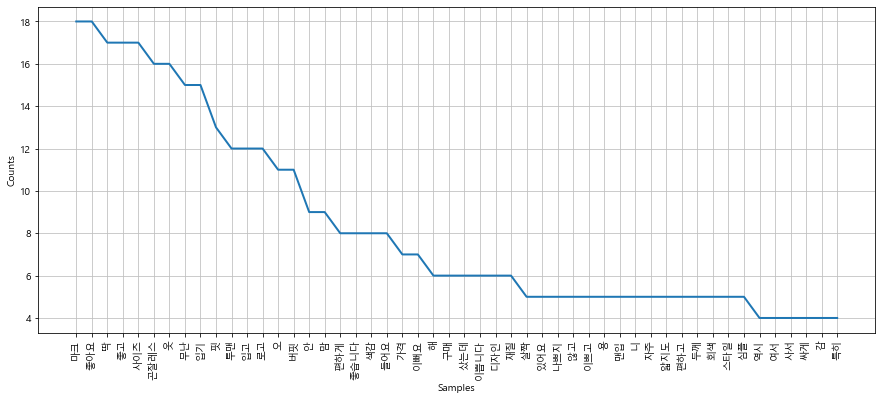

In [81]:
plt.figure(figsize=(15,6))
ko.plot(50) 
plt.show()

In [82]:
data = ko.vocab().most_common(300)
data

[('마크', 18),
 ('좋아요', 18),
 ('딱', 17),
 ('좋고', 17),
 ('사이즈', 17),
 ('곤잘레스', 16),
 ('옷', 16),
 ('무난', 15),
 ('입기', 15),
 ('핏', 13),
 ('투맨', 12),
 ('입고', 12),
 ('로고', 12),
 ('오', 11),
 ('버핏', 11),
 ('안', 9),
 ('맘', 9),
 ('편하게', 8),
 ('좋습니다', 8),
 ('색감', 8),
 ('들어요', 8),
 ('가격', 7),
 ('이뻐요', 7),
 ('해', 6),
 ('구매', 6),
 ('샀는데', 6),
 ('이쁩니다', 6),
 ('디자인', 6),
 ('재질', 6),
 ('살짝', 5),
 ('있어요', 5),
 ('나쁘지', 5),
 ('않고', 5),
 ('이쁘고', 5),
 ('용', 5),
 ('맨입', 5),
 ('니', 5),
 ('자주', 5),
 ('얇지도', 5),
 ('편하고', 5),
 ('두께', 5),
 ('회색', 5),
 ('스타일', 5),
 ('심플', 5),
 ('역시', 4),
 ('여서', 4),
 ('사서', 4),
 ('싸게', 4),
 ('감', 4),
 ('특히', 4),
 ('흰', 4),
 ('티', 4),
 ('좋은', 4),
 ('해요', 4),
 ('정도', 4),
 ('않을', 4),
 ('맞고', 4),
 ('입', 4),
 ('적당한', 4),
 ('깔끔하고', 4),
 ('가을', 4),
 ('좋아서', 4),
 ('다른', 4),
 ('색상', 4),
 ('이쁘네요', 4),
 ('생각', 4),
 ('길이', 4),
 ('스몰', 4),
 ('정말', 4),
 ('추천', 4),
 ('좋네요', 4),
 ('느낌', 4),
 ('같습니다', 4),
 ('희', 4),
 ('실루엣', 4),
 ('그런지', 3),
 ('하네요', 3),
 ('블랙', 3),
 ('듯', 3),
 ('분', 3),
 ('이에요', 3

In [83]:
from wordcloud import WordCloud, STOPWORDS
from PIL import Image

In [84]:
import matplotlib.pyplot as plt

from matplotlib import font_manager

font_fname = 'c:/Windows/Fonts/malgun.ttf'

font_family = font_manager.FontProperties(fname=font_fname).get_name()

plt.rcParams["font.family"] = font_family

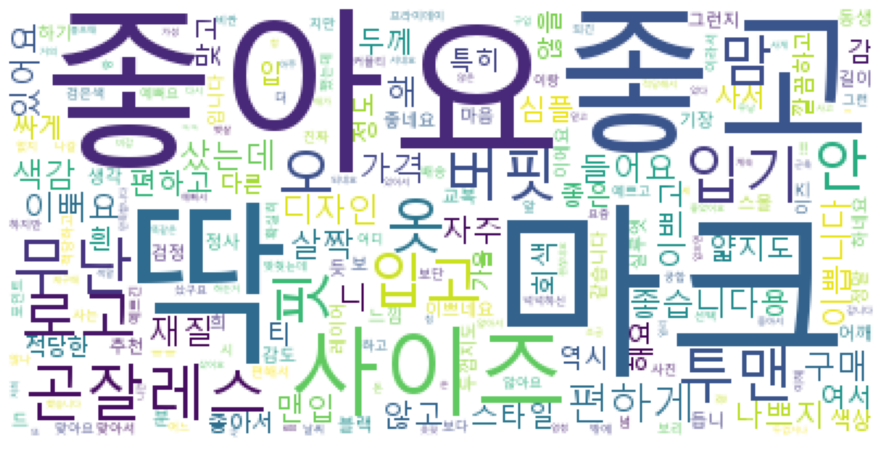

In [85]:

wordcloud = WordCloud(font_path='malgun',  # 윈도우:'c:/Windows/Fonts/malgun.ttf'
                      relative_scaling = 0.2, 
                      #stopwords=STOPWORDS,
                      background_color='white'
                      ).generate_from_frequencies(dict(data))
plt.figure(figsize=(16,8))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

In [86]:
import re 
# 텍스트 값 리스트로 변환
result=[]
res = [] 
height_list = Mans.height.values.tolist()
# cm 빼고 정수형으로 전환 
for i in range(len(height_list)):
    result.append(re.findall('\d+',height_list[i]))
    res.append(int(result[i][0]))
print(res)

TypeError: expected string or bytes-like object

In [33]:
# cm 빼고 정수형으로 전환 
weight_list = Mans.weight.values.tolist()
result2 = []
res2 = []
for i in range(len(weight_list)):
    result2.append((re.findall('\d+',weight_list[i])))
    res2.append(int(result2[i][0]))
print(res2)

[62, 60, 72, 80, 65, 44, 65, 70, 85, 62, 60, 72, 80, 65, 44, 65, 70, 85, 56, 72, 80, 72, 83, 50, 58, 65, 75, 51, 74, 70, 80, 68, 60, 63, 60, 70, 80, 80, 83, 75, 64, 70, 78, 70, 82, 65, 82, 95, 75, 127, 78, 70, 82, 65, 82, 95, 75, 127, 95, 60, 78, 88, 63, 66, 66, 70, 70, 95, 70, 63, 73, 65, 67, 78, 73, 86]


In [34]:
# 기존 키 무게 삭제
Mans = Mans.drop(['height','weight'],axis=1)

In [35]:
# 새로운 정수형 키 추가 
Mans.insert(1,'height',res)

In [36]:
# 정수형 무게 추가 
Mans.insert(2,'weight',res2)

In [37]:
Mans

,gender,height,weight,fit,size
0,남성,178,62,커요,L
2,남성,178,60,보통이에요,M
3,남성,182,72,보통이에요,L
4,남성,165,80,보통이에요,XL
5,남성,170,65,커요,M
...,...,...,...,...,...
85,남성,170,65,보통이에요,M
86,남성,178,67,보통이에요,L
87,남성,174,78,보통이에요,XL
88,남성,180,73,커요,L


In [38]:
#각 갯수 만큼 counts
big = (Mans.height >= 165) & (Mans.height < 175) & (Mans['size']== 'L')
mid = (Mans.height >= 165) & (Mans.height < 175) & (Mans['size']=='M')
small = (Mans.height >= 165) & (Mans.height < 175) & (Mans['size']== 'S')

big_counts = Mans.loc[big]
big_counts['counts']=1
mid_counts = Mans.loc[mid]
mid_counts['counts']=1
sm_counts = Mans.loc[small]
sm_counts['counts']=1

# 사이즈별 데이터 프레임 병합
satis_count = pd.concat([big_counts,mid_counts,sm_counts])

In [40]:
mid_counts

,gender,height,weight,fit,size,counts
5,남성,170,65,커요,M,1
15,남성,170,65,커요,M,1
25,남성,170,50,보통이에요,M,1
26,남성,171,58,보통이에요,M,1
30,남성,166,51,보통이에요,M,1
32,남성,173,70,보통이에요,M,1
34,남성,167,68,보통이에요,M,1
35,남성,172,60,보통이에요,M,1
40,남성,171,60,보통이에요,M,1
47,남성,173,64,커요,M,1


In [89]:
satis_count
satis_165_175 = satis_count[['fit','size','counts']]

In [90]:
ans = satis_165_175.groupby(['fit','size']).sum()
ans

counts
fit   size        
보통이에요 L          6
      M         11
      S          3
커요    M          3

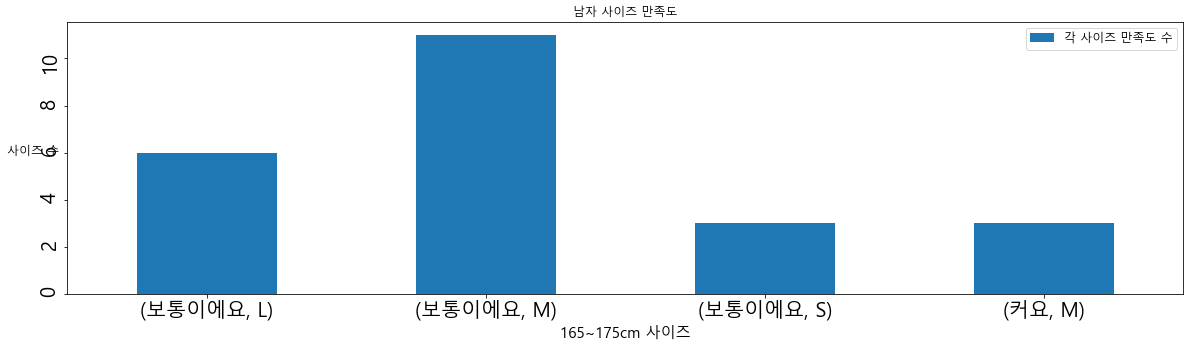

In [91]:
#한글 꺠짐 방지
plt.rcParams['font.family'] ='Malgun Gothic'
plt.rcParams['axes.unicode_minus'] =False
 
# 차트 종류, 제목, 차트 크기, 범례, 폰트 크기 설정
ax = ans.plot(kind='bar', title='남자 사이즈 만족도', figsize=(20, 5), legend=True, fontsize=20)
ax.set_xlabel('165~175cm 사이즈', fontsize=15)          # x축 정보 표시
plt.xticks(rotation=0)
plt.yticks(rotation=90)
h= plt.ylabel('사이즈 수 ', fontsize=12)     # y축 정보 표시
h.set_rotation(0)
ax.legend(['각 사이즈 만족도 수'], fontsize=12)    # 범례 지정

데이터 시각화로  165~175cm인 사람들은 이 옷 구매시 
M 사이즈면 딱 맞는다는 것을 한눈에 확인 가능하다.

In [92]:
Girls

,gender,fit,size
1,여성,보통이에요,S
11,여성,보통이에요,S
29,여성,보통이에요,M
36,여성,보통이에요,M
37,여성,보통이에요,S
39,여성,커요,M
44,여성,커요,S
49,여성,보통이에요,S
53,여성,보통이에요,S
56,여성,커요,XL


In [88]:
# 텍스트 값 리스트로 변환
G_result=[]
G_res = [] 
G_height_list = Girls.height.values.tolist()
# cm 빼고 정수형으로 전환 
for i in range(len(G_height_list)):
    G_result.append(re.findall('\d+',G_height_list[i]))
    G_res.append(int(G_result[i][0]))

# cm 빼고 정수형으로 전환 
G_weight_list = Girls.weight.values.tolist()
G_result2 = []
G_res2 = []
for i in range(len(G_weight_list)):
    G_result2.append((re.findall('\d+',G_weight_list[i])))
    G_res2.append(int(G_result2[i][0]))

AttributeError: 'DataFrame' object has no attribute 'height'

In [65]:
# 기존 키 무게 삭제
Girls = Girls.drop(['height','weight'],axis=1)

In [48]:
# 새로운 정수형 키 추가 
Girls.insert(1,'height',G_res)

In [49]:
# 정수형 무게 추가 
Girls.insert(2,'weight',G_res2)

In [50]:
Girls

,gender,height,weight,fit,size
1,여성,165,50,보통이에요,S
11,여성,165,50,보통이에요,S
29,여성,160,74,보통이에요,M
36,여성,168,45,보통이에요,M
37,여성,162,54,보통이에요,S
39,여성,164,56,커요,M
44,여성,164,47,커요,S
49,여성,160,60,보통이에요,S
53,여성,158,50,보통이에요,S
56,여성,157,57,커요,XL


In [69]:
#각 갯수 만큼 counts
big = (Girls.height >= 165) & (Girls.height < 175) & (Girls['size']== 'L')
mid = (Girls.height >= 165) & (Girls.height < 175) & (Girls['size']=='M')
small = (Girls.height >= 165) & (Girls.height < 175) & (Girls['size']== 'S')

big_counts = Girls.loc[big]
big_counts['counts']=1
mid_counts = Girls.loc[mid]
mid_counts['counts']=1
sm_counts = Girls.loc[small]
sm_counts['counts']=1

# 사이즈별 데이터 프레임 병합
G_satis_count = pd.concat([big_counts,mid_counts,sm_counts])

AttributeError: 'DataFrame' object has no attribute 'height'

In [52]:
G_satis_165_175 = satis_count[['fit','size','counts']]

In [53]:
big_counts

,gender,height,weight,fit,size,counts


In [54]:
mid_counts

,gender,height,weight,fit,size,counts
36,여성,168,45,보통이에요,M,1
72,여성,167,51,보통이에요,M,1
74,여성,171,58,보통이에요,M,1


In [59]:
sm_counts

,gender,height,weight,fit,size,counts
1,여성,165,50,보통이에요,S,1
11,여성,165,50,보통이에요,S,1


In [60]:
G_ans = G_satis_165_175.groupby(['fit','size']).sum()

In [63]:
G_ans

counts
fit   size        
보통이에요 L          6
      M         11
      S          3
커요    M          3

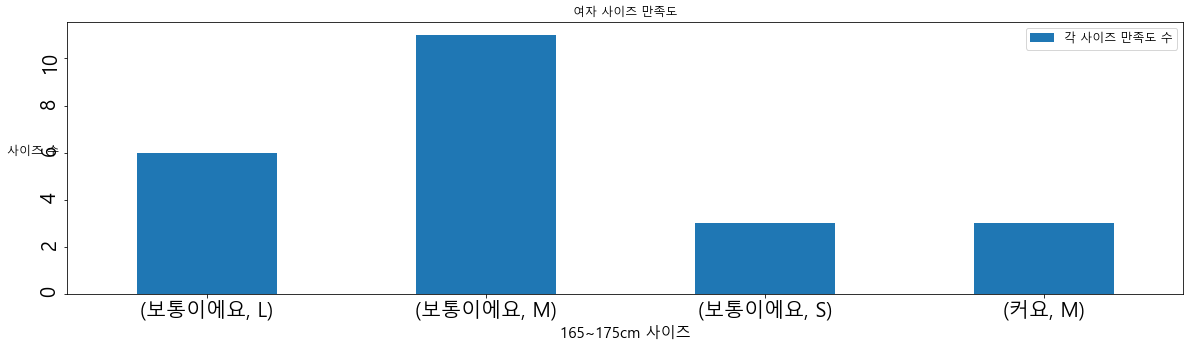

In [62]:
#한글 꺠짐 방지
plt.rcParams['font.family'] ='Malgun Gothic'
plt.rcParams['axes.unicode_minus'] =False
 
# 차트 종류, 제목, 차트 크기, 범례, 폰트 크기 설정
ax = G_ans.plot(kind='bar', title='여자 사이즈 만족도', figsize=(20, 5), legend=True, fontsize=20)
ax.set_xlabel('165~175cm 사이즈', fontsize=15)          # x축 정보 표시
plt.xticks(rotation=0)
plt.yticks(rotation=90)
h= plt.ylabel('사이즈 수 ', fontsize=12)     # y축 정보 표시
h.set_rotation(0)
ax.legend(['각 사이즈 만족도 수'], fontsize=12)    # 범례 지정

여성구매자 신장 165~175cm의 구매자들의 만족도를 시각화하여 보였다.